# Data Loading Function

In [5]:
import csv
import numpy as np

# Function to load metrics from the metrics CSV file
def load_metrics(csv_filename):
    epochs = []
    train_losses = []
    test_losses = []
    test_accuracies = []
    test_f1_scores = []

    with open(csv_filename, mode="r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header

        for row in reader:
            epochs.append(int(row[0]))                   # Epoch number
            train_losses.append(float(row[1]))           # Train Loss
            test_losses.append(float(row[2]))            # Test Loss
            test_accuracies.append(float(row[3]))        # Test Accuracy
            
            # Process the F1 score string, remove unwanted characters and convert to list of floats
            f1_str = row[4].strip("[]\n ")
            f1_scores = list(map(float, f1_str.split()))
            test_f1_scores.append(f1_scores)

    return epochs, train_losses, test_losses, test_accuracies, test_f1_scores

# Function to load all labels, predictions, and probabilities
def load_predictions(csv_filename):
    all_labels = []
    all_preds = []
    all_probs = []

    with open(csv_filename, mode="r") as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            # True label (single integer in the first column)
            labels = int(row[0])
            # Predicted label (single integer in the second column)
            preds = int(row[1])
            # Probabilities (list of floats, starts from the third column onward)
            probs = list(map(float, row[2:]))  # Probabilities are the rest of the row
            
            # Append data to the lists
            all_labels.append(labels)
            all_preds.append(preds)
            all_probs.append(probs)
    
    # Convert to numpy arrays for easier manipulation later
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)




# Plotting Graph Function

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_metrics(model1_metrics, model2_metrics, model3_metrics, class_names=None, model1_name='Model 1', model2_name='Model 2', model3_name='Model 3'):
    """
    Plots multiple metrics for three different models:
    1. Training vs Testing Loss
    2. Test Accuracy over Epochs
    3. F1 Score over Epochs
    4. Macro ROC Curve
    5. Test Accuracy per Class (Final Epoch)
    6. F1 Score per Class (Final Epoch)
    
    Args:
    model1_metrics, model2_metrics, model3_metrics: Tuples containing metrics for each model
    class_names: List of class names for bar charts
    model1_name, model2_name, model3_name: Strings representing the names of the models to be displayed on plots
    """
    
    # Unpack the metrics for each model
    epochs1, train_losses1, test_losses1, test_accuracy1, test_f1_1, all_labels1, _, all_probs1 = model1_metrics
    epochs2, train_losses2, test_losses2, test_accuracy2, test_f1_2, all_labels2, _, all_probs2 = model2_metrics
    epochs3, train_losses3, test_losses3, test_accuracy3, test_f1_3, all_labels3, _, all_probs3 = model3_metrics

    # Define colors for each model
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    # 1. Plot Training and Testing Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)  # First subplot
    plt.plot(epochs1, train_losses1, color=colors[0], label=f'{model1_name} Train Loss')
    plt.plot(epochs1, test_losses1, color=colors[0], linestyle='dashed', label=f'{model1_name} Test Loss')
    plt.plot(epochs2, train_losses2, color=colors[1], label=f'{model2_name} Train Loss')
    plt.plot(epochs2, test_losses2, color=colors[1], linestyle='dashed', label=f'{model2_name} Test Loss')
    plt.plot(epochs3, train_losses3, color=colors[2], label=f'{model3_name} Train Loss')
    plt.plot(epochs3, test_losses3, color=colors[2], linestyle='dashed', label=f'{model3_name} Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss for all Models')
    plt.legend()
    plt.grid(True)

    # 2. Plot Test Accuracy over Epochs
    plt.subplot(2, 2, 2)  # Second subplot
    plt.plot(epochs1, test_accuracy1, color=colors[0], label=f'{model1_name} Test Accuracy')
    plt.plot(epochs2, test_accuracy2, color=colors[1], label=f'{model2_name} Test Accuracy')
    plt.plot(epochs3, test_accuracy3, color=colors[2], label=f'{model3_name} Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy over Epochs for all Models')
    plt.legend()
    plt.grid(True)

    # 3. Plot F1 Score over Epochs
    plt.subplot(2, 2, 3)  # Third subplot
    plt.plot(epochs1, np.mean(test_f1_1, axis=1), color=colors[0], label=f'{model1_name} F1 Score')
    plt.plot(epochs2, np.mean(test_f1_2, axis=1), color=colors[1], label=f'{model2_name} F1 Score')
    plt.plot(epochs3, np.mean(test_f1_3, axis=1), color=colors[2], label=f'{model3_name} F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Macro F1 Score over Epochs for all Models')
    plt.legend()
    plt.grid(True)

    # 4. Plot Macro ROC Curve
    # Binarize the true labels for each model
    num_classes = 10
    all_labels_bin1 = label_binarize(all_labels1, classes=[i for i in range(num_classes)])
    all_labels_bin2 = label_binarize(all_labels2, classes=[i for i in range(num_classes)])
    all_labels_bin3 = label_binarize(all_labels3, classes=[i for i in range(num_classes)])

    # Initialize dictionaries for storing fpr, tpr, and auc values for each class
    roc_auc1 = dict()
    fpr1 = dict()
    tpr1 = dict()

    roc_auc2 = dict()
    fpr2 = dict()
    tpr2 = dict()

    roc_auc3 = dict()
    fpr3 = dict()
    tpr3 = dict()

    # Compute ROC for each class and its AUC for all models
    for i in range(num_classes):
        fpr1[i], tpr1[i], _ = roc_curve(all_labels_bin1[:, i], all_probs1[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

        fpr2[i], tpr2[i], _ = roc_curve(all_labels_bin2[:, i], all_probs2[:, i])
        roc_auc2[i] = auc(fpr2[i], tpr2[i])

        fpr3[i], tpr3[i], _ = roc_curve(all_labels_bin3[:, i], all_probs3[:, i])
        roc_auc3[i] = auc(fpr3[i], tpr3[i])

    # Compute the macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr1[i] for i in range(num_classes)]))
    mean_tpr1 = np.zeros_like(all_fpr)
    mean_tpr2 = np.zeros_like(all_fpr)
    mean_tpr3 = np.zeros_like(all_fpr)

    for i in range(num_classes):
        mean_tpr1 += np.interp(all_fpr, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr, fpr2[i], tpr2[i])
        mean_tpr3 += np.interp(all_fpr, fpr3[i], tpr3[i])

    mean_tpr1 /= num_classes
    mean_tpr2 /= num_classes
    mean_tpr3 /= num_classes

    fpr1["macro"] = all_fpr
    tpr1["macro"] = mean_tpr1
    roc_auc1["macro"] = auc(fpr1["macro"], tpr1["macro"])

    fpr2["macro"] = all_fpr
    tpr2["macro"] = mean_tpr2
    roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])

    fpr3["macro"] = all_fpr
    tpr3["macro"] = mean_tpr3
    roc_auc3["macro"] = auc(fpr3["macro"], tpr3["macro"])

    # Plot the macro ROC curves for all models
    plt.subplot(2, 2, 4)  # Fourth subplot
    plt.plot(fpr1["macro"], tpr1["macro"], color=colors[0], label=f'{model1_name} ROC curve (area = {roc_auc1["macro"]:.5f})')
    plt.plot(fpr2["macro"], tpr2["macro"], color=colors[1], label=f'{model2_name} ROC curve (area = {roc_auc2["macro"]:.5f})')
    plt.plot(fpr3["macro"], tpr3["macro"], color=colors[2], label=f'{model3_name} ROC curve (area = {roc_auc3["macro"]:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Show the 2x2 grid of the first four plots
    plt.tight_layout()
    plt.show()

    # 5. Plot Test Accuracy per Class at Final Epoch (Bar chart)
    final_epoch_idx = -1  # Final epoch index
    class_accuracy_model1 = test_accuracy1[final_epoch_idx]  # Test Accuracy per class for Model 1
    class_accuracy_model2 = test_accuracy2[final_epoch_idx]  # Test Accuracy per class for Model 2
    class_accuracy_model3 = test_accuracy3[final_epoch_idx]  # Test Accuracy per class for Model 3

    plt.figure(figsize=(12, 6))
    x = np.arange(len(class_names))  # Number of classes
    width = 0.2  # Bar width

    plt.bar(x - width, class_accuracy_model1, width, label=model1_name)
    plt.bar(x, class_accuracy_model2, width, label=model2_name)
    plt.bar(x + width, class_accuracy_model3, width, label=model3_name)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy per Class at Final Epoch')
    plt.xticks(x, class_names)
    plt.legend()
    plt.show()

    # 6. Plot F1 Score per Class at Final Epoch (Bar chart)
    f1_scores_model1 = np.mean(test_f1_1[final_epoch_idx], axis=0)  # F1 per class for Model 1
    f1_scores_model2 = np.mean(test_f1_2[final_epoch_idx], axis=0)  # F1 per class for Model 2
    f1_scores_model3 = np.mean(test_f1_3[final_epoch_idx], axis=0)  # F1 per class for Model 3

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, f1_scores_model1, width, label=model1_name)
    plt.bar(x, f1_scores_model2, width, label=model2_name)
    plt.bar(x + width, f1_scores_model3, width, label=model3_name)
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Class at Final Epoch')
    plt.xticks(x, class_names)
    plt.legend()
    plt.show()


# Plot Comparison Function

In [12]:
def comparison(modelName1, modelName2, modelName3):
    # Load metrics and predictions separately for each model
    model1_metrics = load_metrics(f"{modelName1}_metrics.csv")
    model1_predictions = load_predictions(f"{modelName1}_predictions.csv")

    model2_metrics = load_metrics(f"{modelName2}_metrics.csv")
    model2_predictions = load_predictions(f"{modelName2}_predictions.csv")

    model3_metrics = load_metrics(f"{modelName3}_metrics.csv")
    model3_predictions = load_predictions(f"{modelName3}_predictions.csv")

    # Combine each model's metrics and predictions into a single tuple
    model1_data = model1_metrics + model1_predictions
    model2_data = model2_metrics + model2_predictions
    model3_data = model3_metrics + model3_predictions

    # Define class names for the plots (assuming 10 classes)
    class_names = [f"Class {i}" for i in range(10)]

    # Now we can call the plotting function with dynamic model names
    plot_metrics(model1_data, model2_data, model3_data, class_names, modelName1, modelName2, modelName3)

    return

# Testing

## 1. Learning Rate

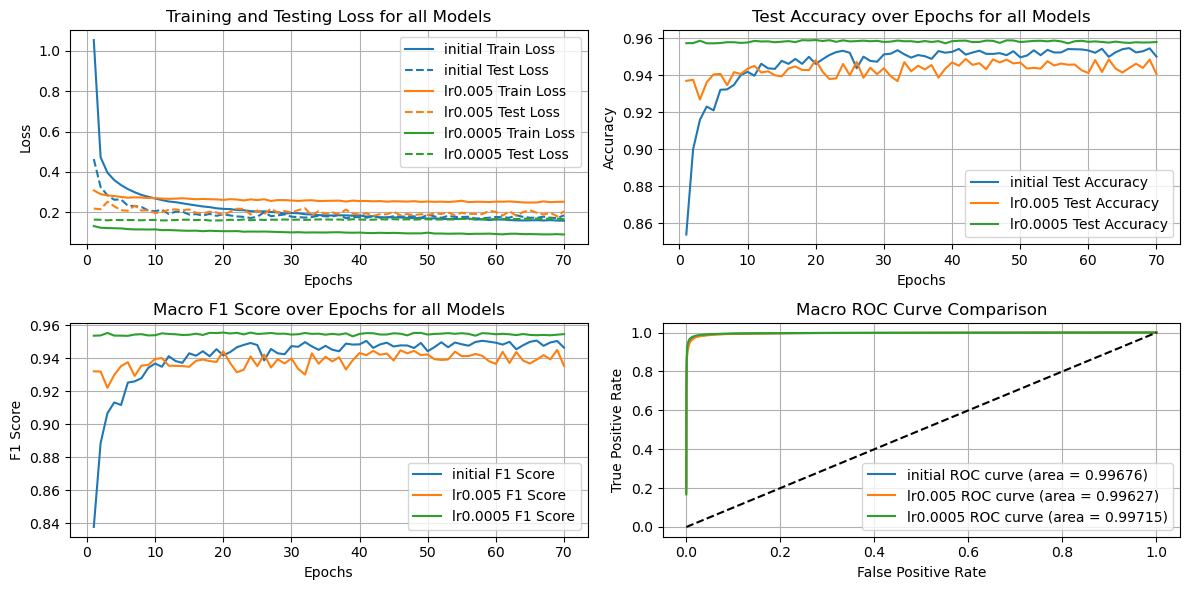

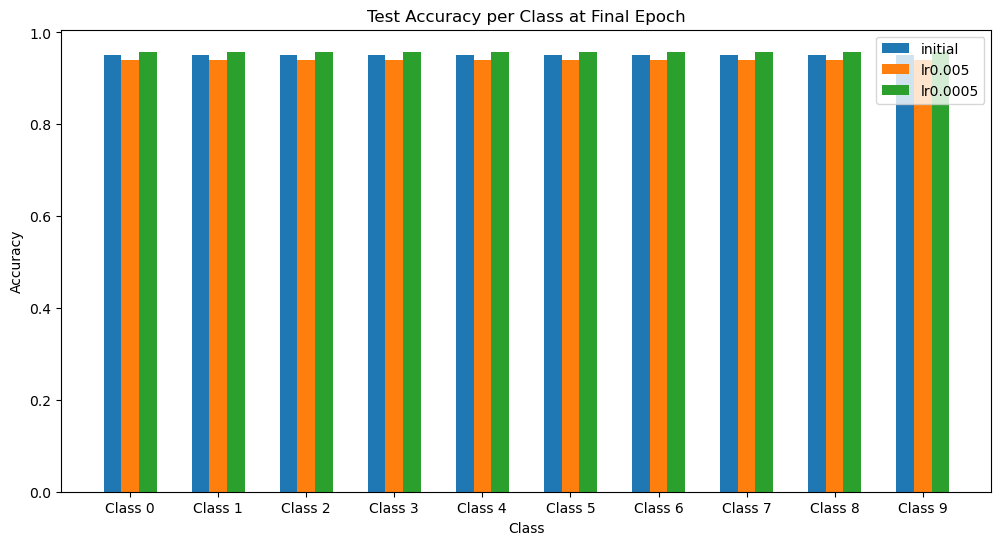

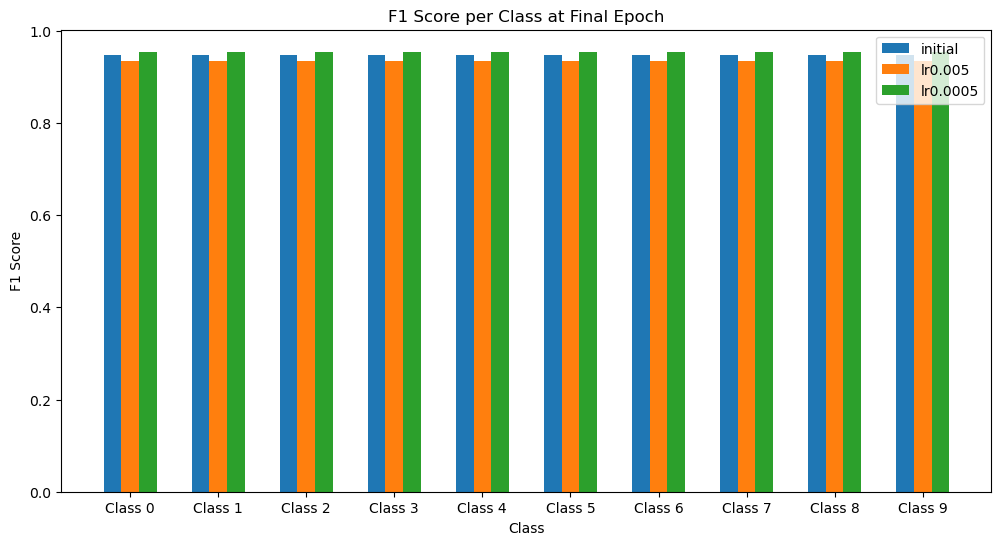

In [13]:
comparison('initial', 'lr0.005','lr0.0005')

## 2. Batch Size

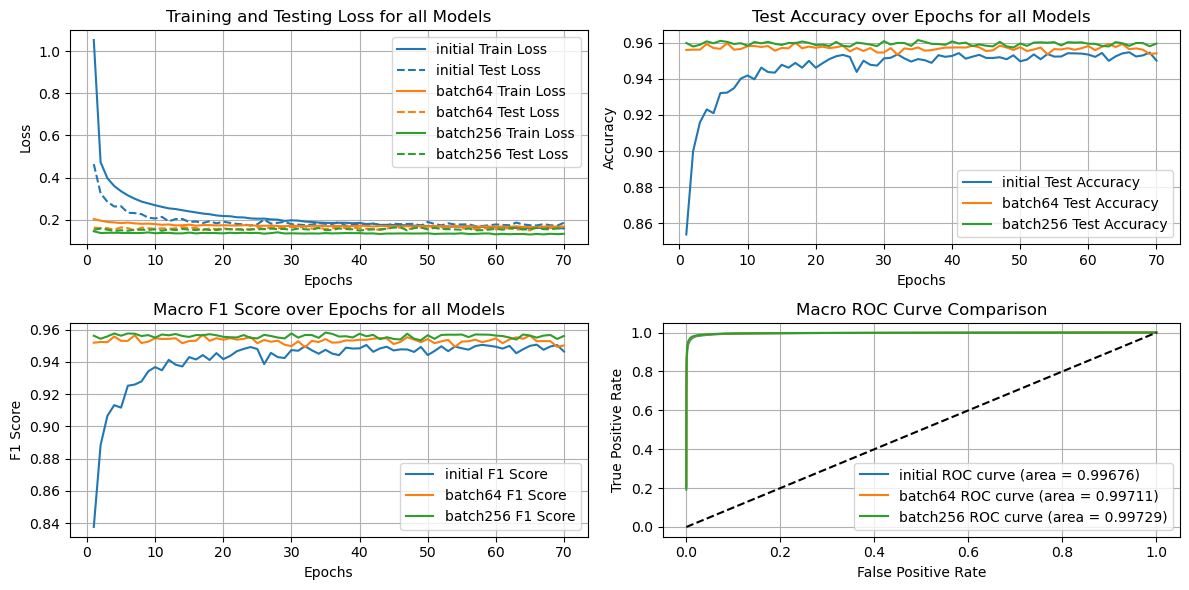

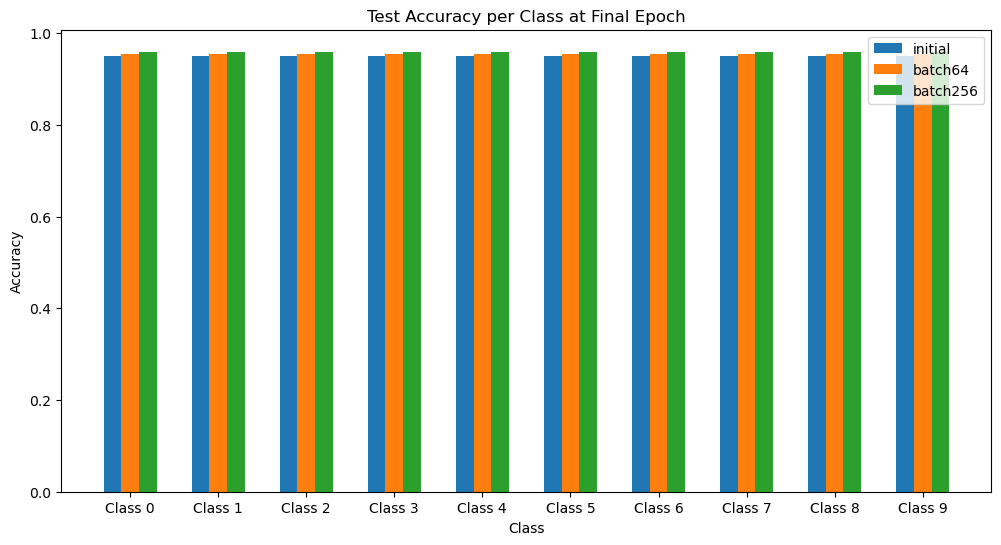

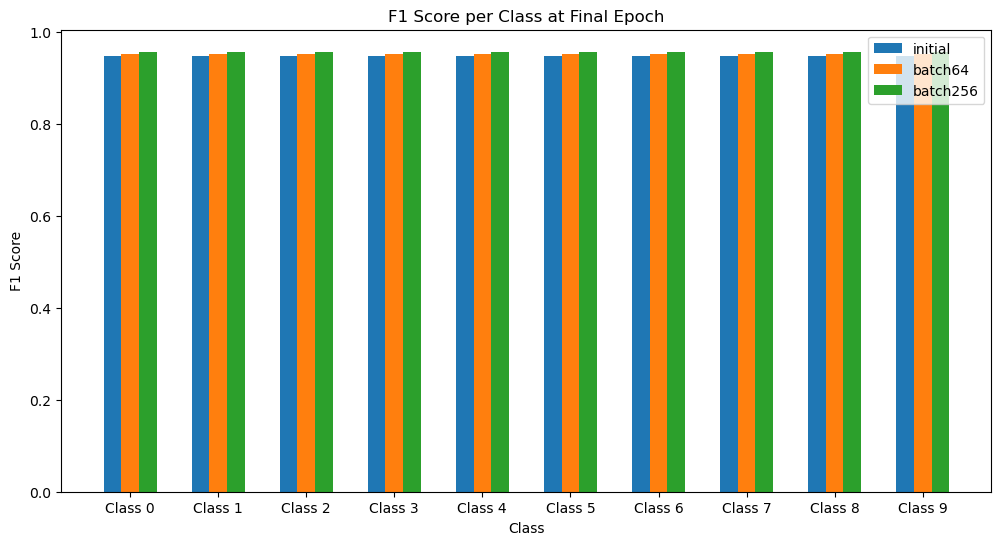

In [14]:
comparison('initial', 'batch64','batch256')

## 3. Num of Epochs

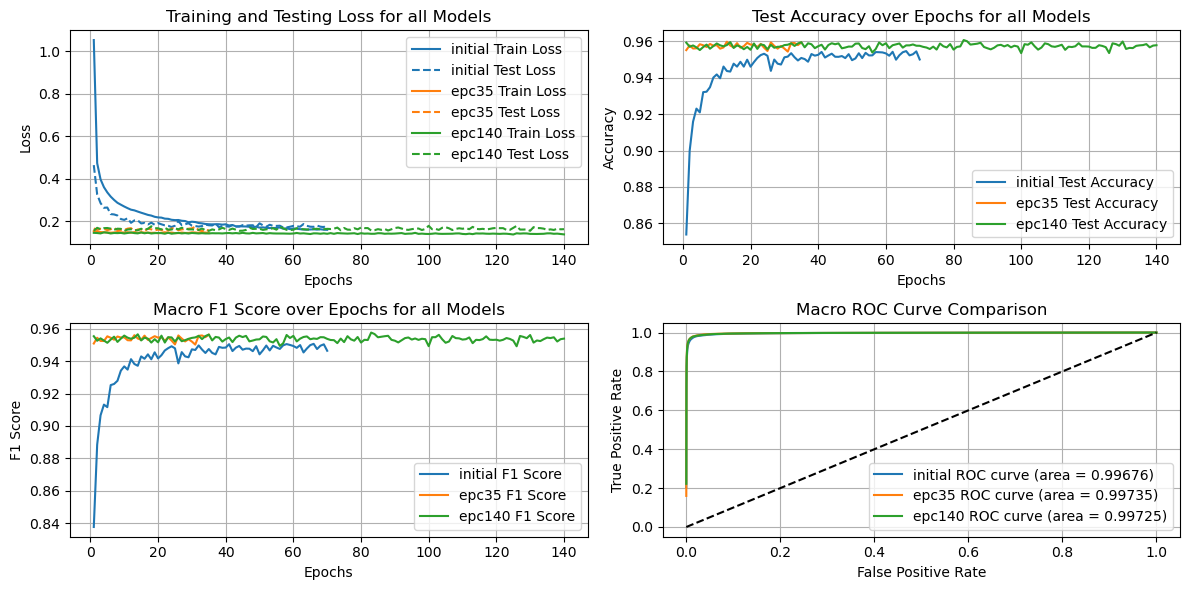

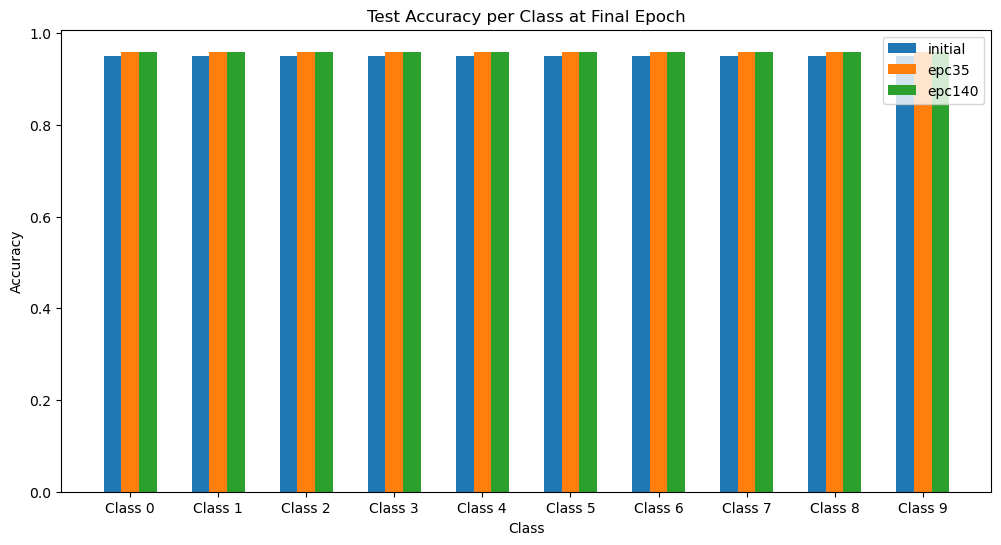

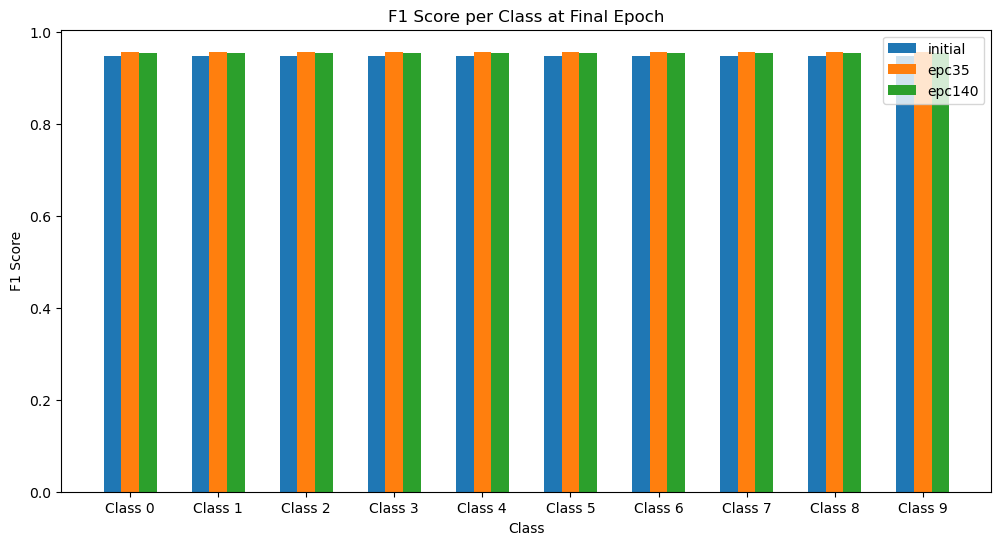

In [15]:
comparison('initial', 'epc35','epc140')

## 4. Optimizer

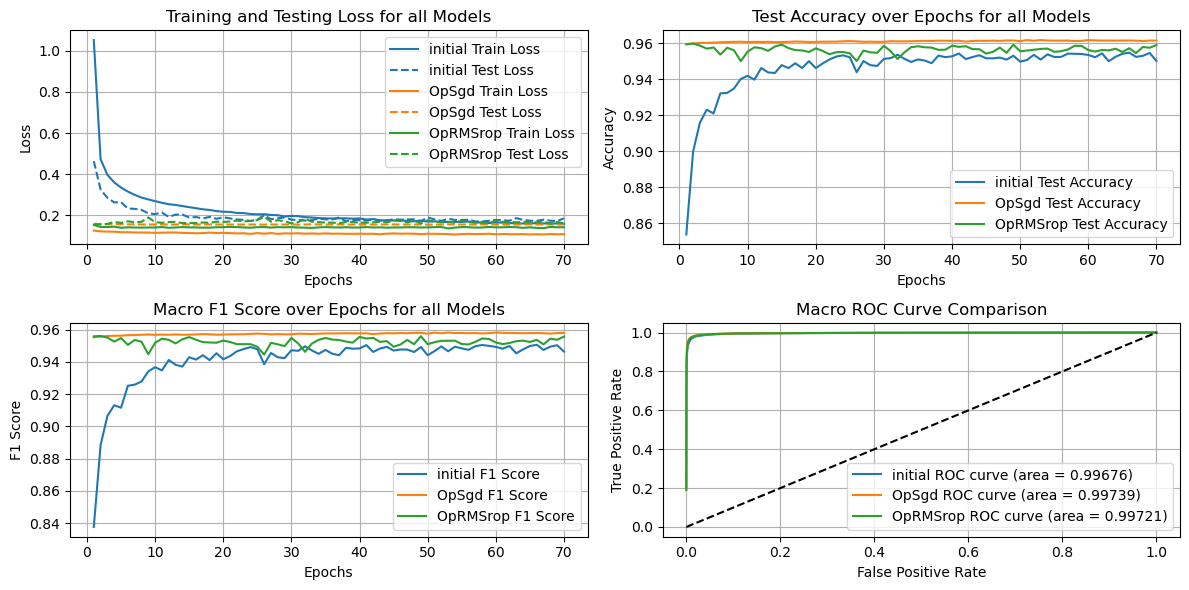

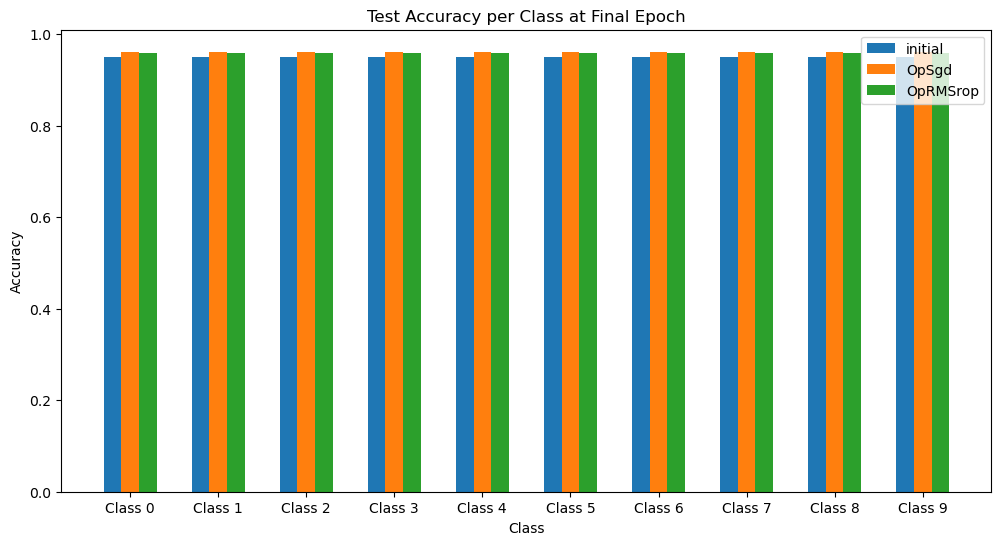

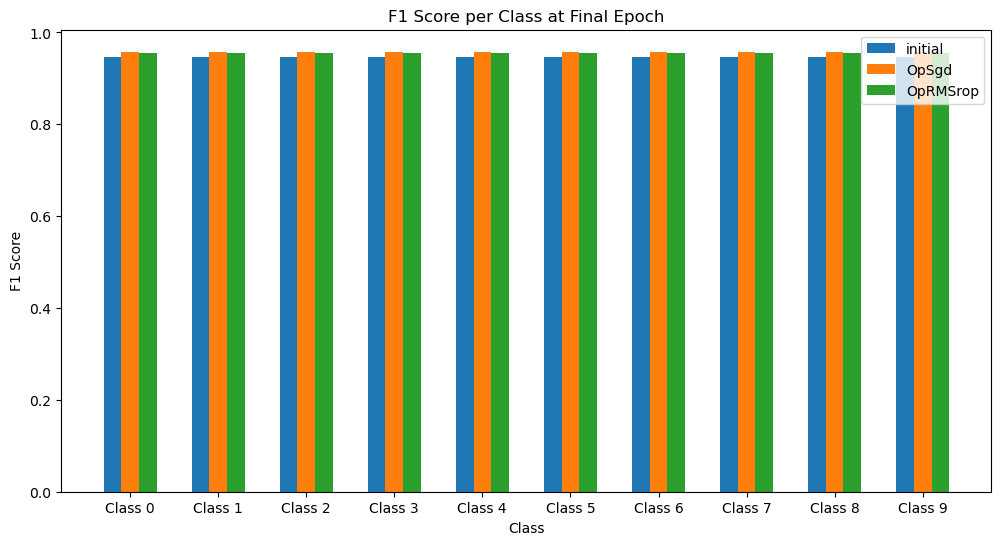

In [16]:
comparison('initial', 'OpSgd','OpRMSrop')

## 5. Rotation

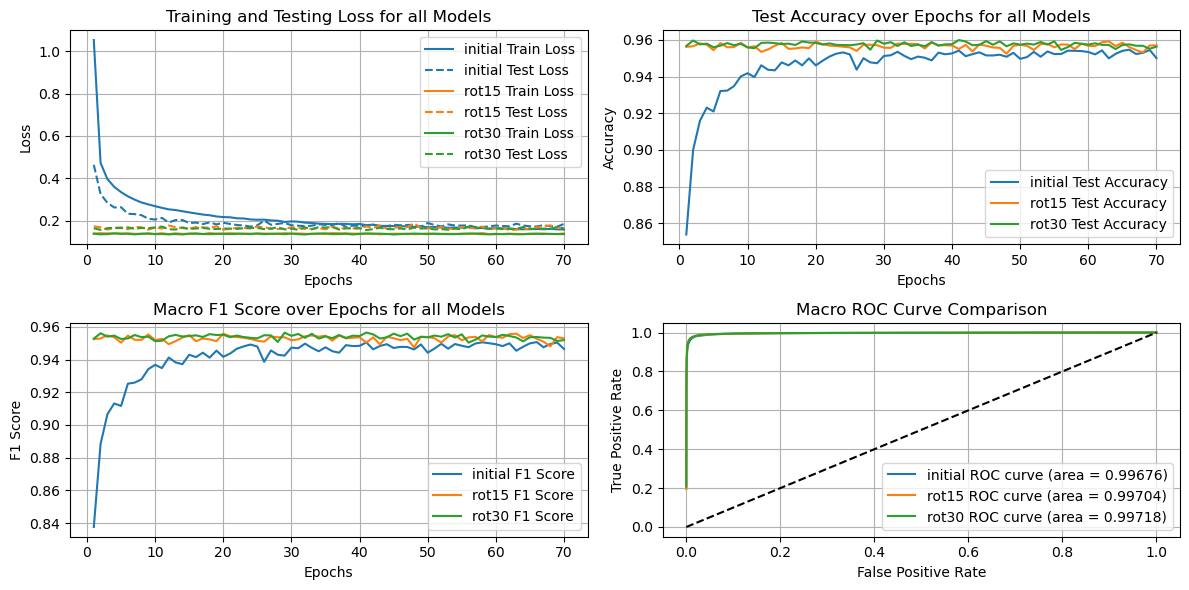

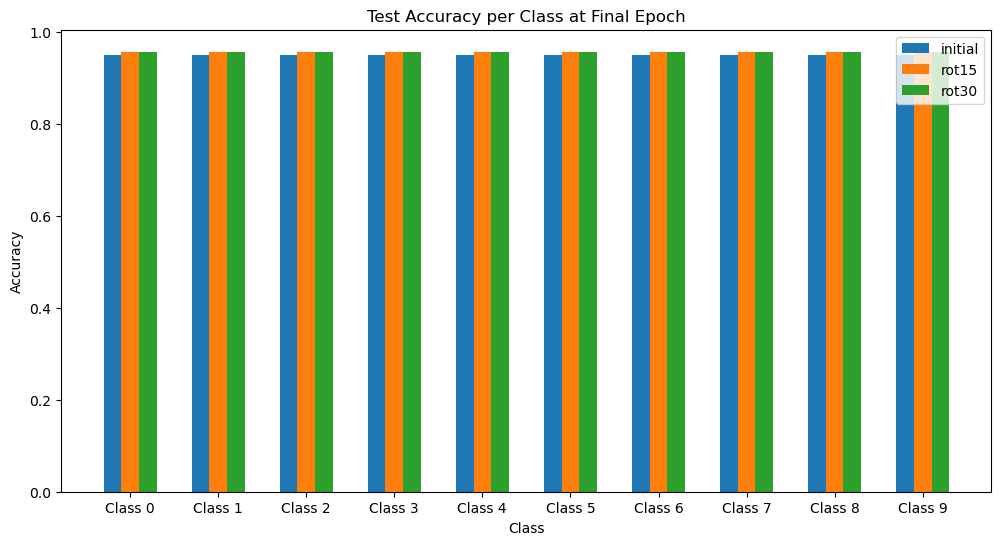

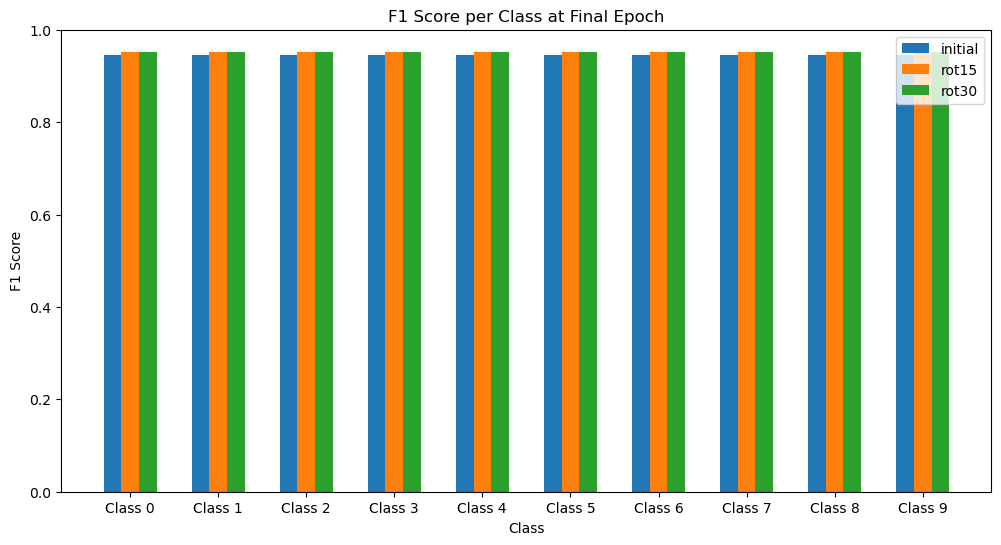

In [17]:
comparison('initial', 'rot15','rot30')

## 6. Crop Scale Range

### Function for plotting results of two model

In [ ]:
def plot_metrics2(model1_metrics, model2_metrics, class_names=None, model1_name='Model 1', model2_name='Model 2'):

    # Unpack the metrics for each model
    epochs1, train_losses1, test_losses1, test_accuracy1, test_f1_1, all_labels1, _, all_probs1 = model1_metrics
    epochs2, train_losses2, test_losses2, test_accuracy2, test_f1_2, all_labels2, _, all_probs2 = model2_metrics

    # Define colors for each model
    colors = ['tab:blue', 'tab:orange']

    # 1. Plot Training and Testing Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)  # First subplot
    plt.plot(epochs1, train_losses1, color=colors[0], label=f'{model1_name} Train Loss')
    plt.plot(epochs1, test_losses1, color=colors[0], linestyle='dashed', label=f'{model1_name} Test Loss')
    plt.plot(epochs2, train_losses2, color=colors[1], label=f'{model2_name} Train Loss')
    plt.plot(epochs2, test_losses2, color=colors[1], linestyle='dashed', label=f'{model2_name} Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss for all Models')
    plt.legend()
    plt.grid(True)

    # 2. Plot Test Accuracy over Epochs
    plt.subplot(2, 2, 2)  # Second subplot
    plt.plot(epochs1, test_accuracy1, color=colors[0], label=f'{model1_name} Test Accuracy')
    plt.plot(epochs2, test_accuracy2, color=colors[1], label=f'{model2_name} Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy over Epochs for all Models')
    plt.legend()
    plt.grid(True)

    # 3. Plot F1 Score over Epochs
    plt.subplot(2, 2, 3)  # Third subplot
    plt.plot(epochs1, np.mean(test_f1_1, axis=1), color=colors[0], label=f'{model1_name} F1 Score')
    plt.plot(epochs2, np.mean(test_f1_2, axis=1), color=colors[1], label=f'{model2_name} F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Macro F1 Score over Epochs for all Models')
    plt.legend()
    plt.grid(True)

    # 4. Plot Macro ROC Curve
    # Binarize the true labels for each model
    num_classes = 10
    all_labels_bin1 = label_binarize(all_labels1, classes=[i for i in range(num_classes)])
    all_labels_bin2 = label_binarize(all_labels2, classes=[i for i in range(num_classes)])

    # Initialize dictionaries for storing fpr, tpr, and auc values for each class
    roc_auc1 = dict()
    fpr1 = dict()
    tpr1 = dict()

    roc_auc2 = dict()
    fpr2 = dict()
    tpr2 = dict()

    # Compute ROC for each class and its AUC for both models
    for i in range(num_classes):
        fpr1[i], tpr1[i], _ = roc_curve(all_labels_bin1[:, i], all_probs1[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

        fpr2[i], tpr2[i], _ = roc_curve(all_labels_bin2[:, i], all_probs2[:, i])
        roc_auc2[i] = auc(fpr2[i], tpr2[i])

    # Compute the macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr1[i] for i in range(num_classes)]))
    mean_tpr1 = np.zeros_like(all_fpr)
    mean_tpr2 = np.zeros_like(all_fpr)

    for i in range(num_classes):
        mean_tpr1 += np.interp(all_fpr, fpr1[i], tpr1[i])
        mean_tpr2 += np.interp(all_fpr, fpr2[i], tpr2[i])

    mean_tpr1 /= num_classes
    mean_tpr2 /= num_classes

    fpr1["macro"] = all_fpr
    tpr1["macro"] = mean_tpr1
    roc_auc1["macro"] = auc(fpr1["macro"], tpr1["macro"])

    fpr2["macro"] = all_fpr
    tpr2["macro"] = mean_tpr2
    roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])

    # Plot the macro ROC curves for both models
    plt.subplot(2, 2, 4)  # Fourth subplot
    plt.plot(fpr1["macro"], tpr1["macro"], color=colors[0], label=f'{model1_name} ROC curve (area = {roc_auc1["macro"]:.5f})')
    plt.plot(fpr2["macro"], tpr2["macro"], color=colors[1], label=f'{model2_name} ROC curve (area = {roc_auc2["macro"]:.5f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Show the 2x2 grid of the first four plots
    plt.tight_layout()
    plt.show()

    # 5. Plot Test Accuracy per Class at Final Epoch (Bar chart)
    final_epoch_idx = -1  # Final epoch index
    class_accuracy_model1 = test_accuracy1[final_epoch_idx]  # Test Accuracy per class for Model 1
    class_accuracy_model2 = test_accuracy2[final_epoch_idx]  # Test Accuracy per class for Model 2

    plt.figure(figsize=(12, 6))
    x = np.arange(len(class_names))  # Number of classes
    width = 0.3  # Bar width

    plt.bar(x - width/2, class_accuracy_model1, width, label=model1_name)
    plt.bar(x + width/2, class_accuracy_model2, width, label=model2_name)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy per Class at Final Epoch')
    plt.xticks(x, class_names)
    plt.legend()
    plt.show()

    # 6. Plot F1 Score per Class at Final Epoch (Bar chart)
    f1_scores_model1 = np.mean(test_f1_1[final_epoch_idx], axis=0)  # F1 per class for Model 1
    f1_scores_model2 = np.mean(test_f1_2[final_epoch_idx], axis=0)  # F1 per class for Model 2

    plt.figure(figsize=(12, 6))
    plt.bar(x - width/2, f1_scores_model1, width, label=model1_name)
    plt.bar(x + width/2, f1_scores_model2, width, label=model2_name)
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Class at Final Epoch')
    plt.xticks(x, class_names)
    plt.legend()
    plt.show()


In [9]:
def comparison2(modelName1, modelName2):
    # Load metrics and predictions separately for each model
    model1_metrics = load_metrics(f"{modelName1}_metrics.csv")
    model1_predictions = load_predictions(f"{modelName1}_predictions.csv")

    model2_metrics = load_metrics(f"{modelName2}_metrics.csv")
    model2_predictions = load_predictions(f"{modelName2}_predictions.csv")

    # Combine each model's metrics and predictions into a single tuple
    model1_data = model1_metrics + model1_predictions
    model2_data = model2_metrics + model2_predictions

    # Define class names for the plots (assuming 10 classes)
    class_names = [f"Class {i}" for i in range(10)]

    # Now we can call the plotting function with dynamic model names
    plot_metrics2(model1_data, model2_data, class_names, modelName1, modelName2)

    return

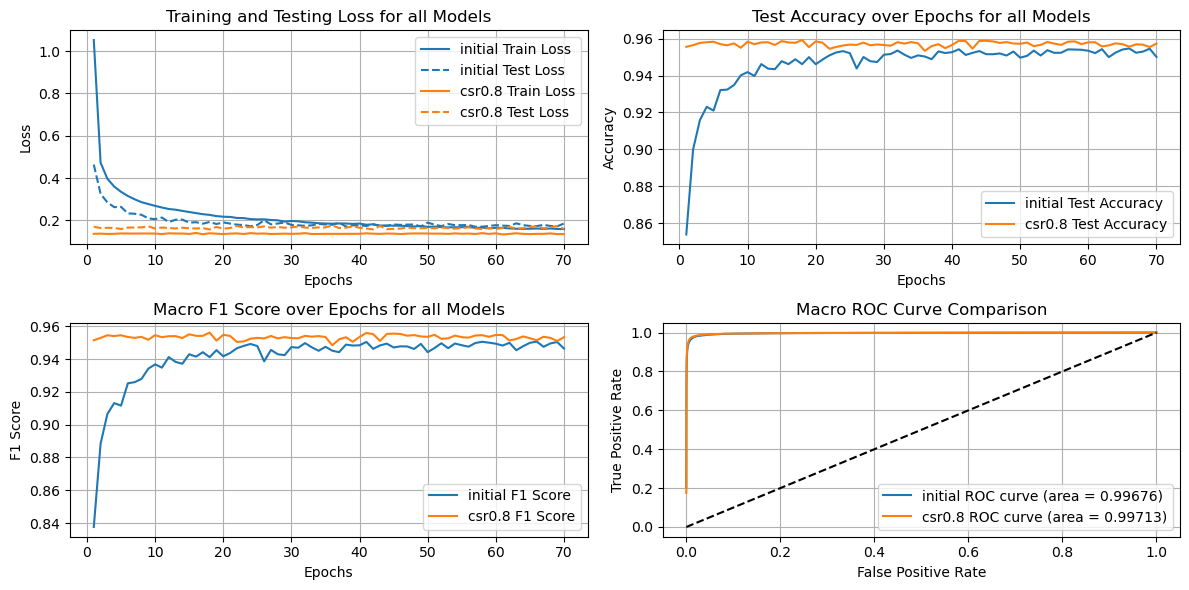

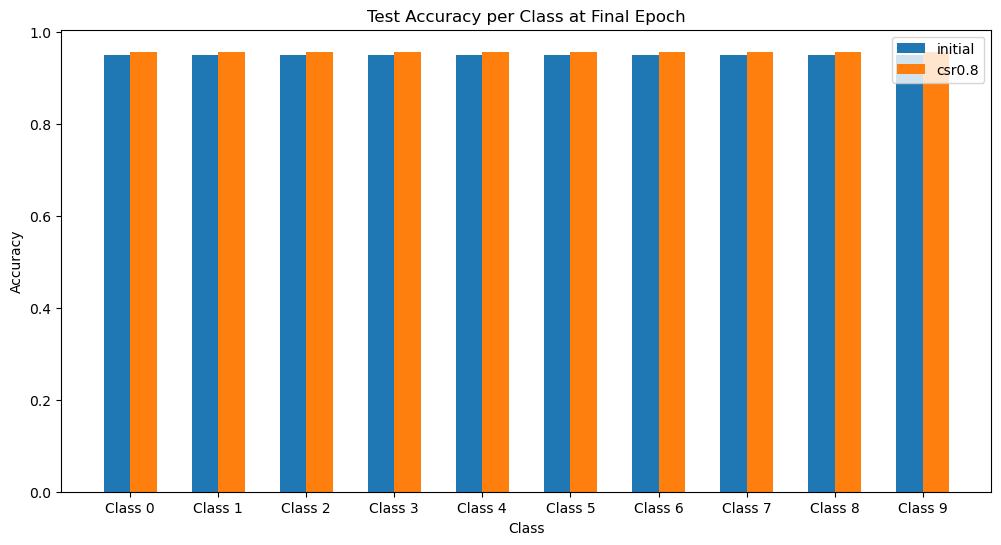

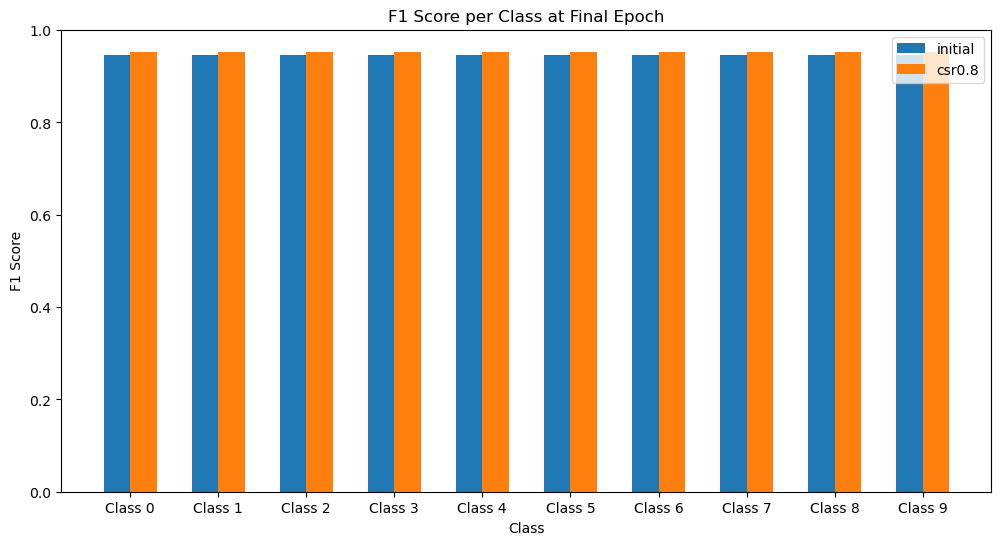

In [12]:
comparison2('initial', 'csr0.8')